In [21]:
#https://github.com/constancedongg/Horse-Racing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

from helper import *

import pandas as pd
import numpy as np

training = pd.read_csv('training.csv')
testing = pd.read_csv('testing.csv')
feats = ['actual_weight','declared_horse_weight','draw','win_odds','jockey_ave_rank','trainer_ave_rank',
'recent_ave_rank','race_distance']
targs = ['HorseWin','HorseRankTop3','HorseRankTop50Percent']
X_train = training[feats]
y_train = training[targs]
X_test = testing[feats]
y_test = testing[targs]

kfold = KFold(n_splits = 5)

In [22]:
## BETTING STUFF
champion_index = testing[testing['HorseWin'] == 1].index.tolist()
champion_odds = testing[testing['HorseWin'] == 1]['win_odds'].tolist()

In [23]:
def count_range_in_list(li, min, max):
    ctr = 0
    for x in li:
        if min <= x <= max:
            ctr += 1
    return ctr
def ele_in_list(li, min, max):
    ele = []
    for x in li:
        if min <= x <= max:
            ele.append(x)
    return ele

def betting_result(champion_odds,champion_index,prediction):
    money=0
    for i in range(len(champion_index)-1):
        ctr= count_range_in_list(prediction,champion_index[i],champion_index[i+1]-1)
        if ctr==0:
            money=money-1
        elif ctr==1:
            money=money-1+champion_odds[i]
        else:
            ele_list=ele_in_list(prediction,champion_index[i],champion_index[i+1]-1)
            if min(ele_list)==champion_index[i]:
                money=money-1+champion_odds[i]
            else:
                money=money-1
    ctr = count_range_in_list(prediction, champion_index[len(champion_index)-1],len(testing['HorseWin'])-1)
    if ctr == 0:
        money = money - 1
    elif ctr == 1:
        money = money - 1 + champion_odds[len(champion_index)-1]
    else:
        ele_list = ele_in_list(prediction, champion_index[len(champion_index)-1], len(testing['HorseWin'])-1)
        if min(ele_list)==champion_index[len(champion_index)-1]:
            money = money - 1 + champion_odds[len(champion_index)-1]
        else:
            money = money - 1
    return money


def myBet(preds, act, odds):
    
    money = [100] #$
    betCount = 0
    for i in range(len(preds)):
        if preds[i]==1:
            # Will bet
            if act[i]==1:
                newMoney = money[betCount] -1 + odds[i]
            else:
                newMoney = money[betCount] - 1
            money.append(newMoney)
            betCount += 1
    return money
    
    

In [24]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train["HorseWin"])
nb = pd.DataFrame({"HorseWin":nb_model.predict(X_test)})
nb_index = nb[nb['HorseWin'] == 1].index.tolist()
print('Betting result:',betting_result(champion_odds,champion_index,nb_index))

Betting result: 2663.4999999999964


In [27]:
def makeBets_1(model, training, X_train, y_train, testing, X_test, y_test, target):
    # Fit and predict
    model.fit(X_train, y_train[target])
    all_preds = model.predict(X_test)
    
    money = [0]
    
    test_race_sizes = [len(testing.loc[testing["race_id"]==race_id]["race_id"]) for race_id in np.unique(testing["race_id"])]
    count = 0
    for s in test_race_sizes:
        lowI = count
        highI = count + s
        preds = all_preds[lowI:highI]
        act = y_test.iloc[lowI:highI,:][target]
        odds = testing.iloc[lowI:highI, :]["win_odds"]
        newMoney = money[-1]

        if sum(preds)==1: # One win, bet on it
            win_horse_i = np.argmax(preds)
            if act.iloc[win_horse_i]==1:
                newMoney = money[-1] - 1 + odds.iloc[win_horse_i]
            else:
                newMoney = money[-1] - 1
        elif sum(preds)>1: # more than one win, find lowest odds one and bet on it
            win_horse_i = np.argmin(odds.iloc[np.where(preds==1)])
            if act.iloc[win_horse_i]==1:
                newMoney = money[-1] - 1 + odds.iloc[win_horse_i]
            else:
                newMoney = money[-1] - 1
            
        money.append(newMoney) 
        count += s
        
    return money


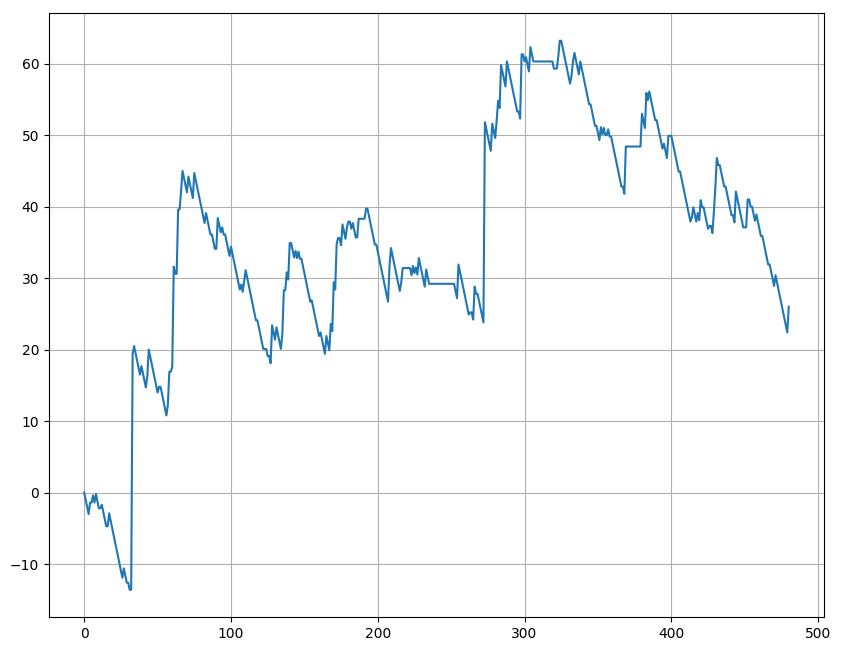

In [28]:
m = makeBets_1(nb_model, training, X_train, y_train, testing, X_test, y_test, "HorseWin")
plt.figure(figsize=(10,8),dpi=100)
plt.plot(m)
plt.grid()

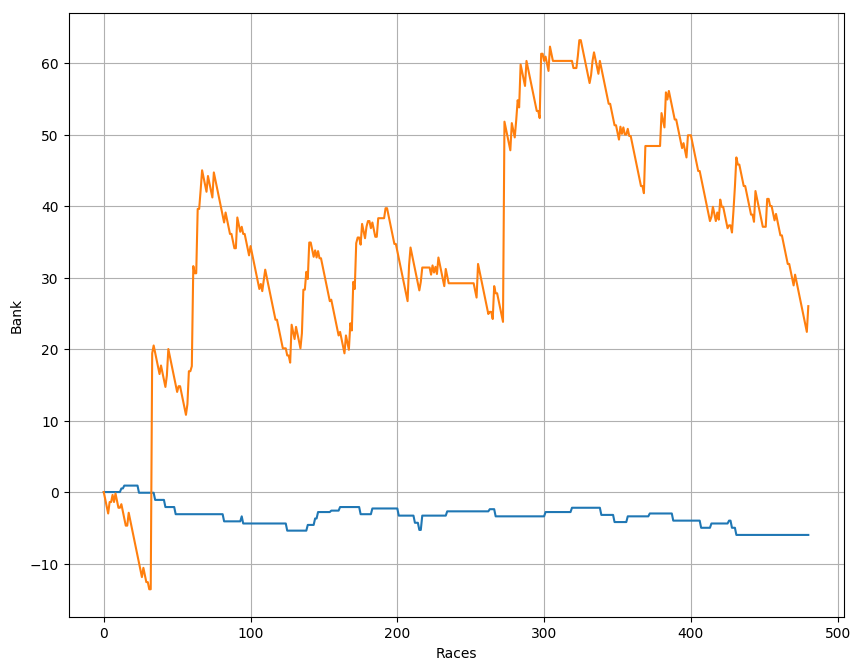

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gb_money = makeBets_1(GradientBoostingClassifier(), training, X_train, y_train, testing, X_test, y_test, "HorseWin")
nb_money = makeBets_1(GaussianNB(), training, X_train, y_train, testing, X_test, y_test, "HorseWin")
plt.figure(figsize=(10,8),dpi=100)
plt.plot(gb_money, label="Gradinet Boosting")
plt.plot(nb_money, label="Gaussian NB")
plt.xlabel("Races")
plt.ylabel("Bank")
plt.grid()

In [ ]:
def makeBetsCV_1(model, training, X_train, y_train, testing, X_test, y_test, target):
    # Fit and predict
    model.fit(X_train, y_train[target])
    all_preds = model.predict(X_test)
    
    money = [0]
    
    test_race_sizes = [len(testing.loc[testing["race_id"]==race_id]["race_id"]) for race_id in np.unique(testing["race_id"])]
    count = 0
    for s in test_race_sizes:
        lowI = count
        highI = count + s
        preds = all_preds[lowI:highI]
        act = y_test.iloc[lowI:highI,:][target]
        odds = testing.iloc[lowI:highI, :]["win_odds"]
        newMoney = money[-1]

        if sum(preds)==1: # One win, bet on it
            win_horse_i = np.argmax(preds)
            if act.iloc[win_horse_i]==1:
                newMoney = money[-1] - 1 + odds.iloc[win_horse_i]
            else:
                newMoney = money[-1] - 1
        elif sum(preds)>1: # more than one win, find lowest odds one and bet on it
            win_horse_i = np.argmin(odds.iloc[np.where(preds==1)])
            if act.iloc[win_horse_i]==1:
                newMoney = money[-1] - 1 + odds.iloc[win_horse_i]
            else:
                newMoney = money[-1] - 1
            
        money.append(newMoney) 
        count += s
        
    return money